In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

# Import custom modules (NEW brand-aware version)
from fusion_models import TextFeatureExtractor, ImageFeatureExtractor, DualTowerFusionModel
from fusion_dataset_v2 import BrandAwareMultiModalDataset, collate_multimodal_batch
from brand_logo_mapper import load_brand_index

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
GPU Memory: 8.59 GB


In [2]:
CONFIG = {
    # Paths
    'text_model_path': 'best_custom_cnn_text_1.pth',
    'image_model_path': 'best_custom_cnn_image_custom.pth',
    'vocab_path': 'vocab_text_1.json',
    'brand_index_path': 'brand_to_images.json',  # NEW
    'email_csv': 'cleaned_combined_emails.csv',
    
    # Training hyperparameters
    'batch_size': 12,  # Reduced for metadata overhead
    'epochs': 10,
    'learning_rate': 1e-4,
    'weight_decay': 1e-4,
    'max_seq_length': 512,
    
    # Model settings
    'embed_dim': 128,
    'metadata_dim': 20,  # NEW
    'dropout': 0.5,
    'num_classes': 2,
    
    # Training strategy
    'freeze_towers_initially': True,
    'unfreeze_after_epoch': 5,
}

print("="*60)
print("Brand-Aware Fusion Training Configuration")
print("="*60)
for k, v in CONFIG.items():
    print(f"  {k}: {v}")
print("="*60)

Brand-Aware Fusion Training Configuration
  text_model_path: best_custom_cnn_text_1.pth
  image_model_path: best_custom_cnn_image_custom.pth
  vocab_path: vocab_text_1.json
  brand_index_path: brand_to_images.json
  email_csv: cleaned_combined_emails.csv
  batch_size: 12
  epochs: 10
  learning_rate: 0.0001
  weight_decay: 0.0001
  max_seq_length: 512
  embed_dim: 128
  metadata_dim: 20
  dropout: 0.5
  num_classes: 2
  freeze_towers_initially: True
  unfreeze_after_epoch: 5


In [3]:
# ONE-TIME SETUP: Build brand-to-images index
print("="*70)
print("Building Brand-to-Images Index (One-Time Setup)")
print("="*70)
print("This will take 2-5 minutes...  Please wait.")
print("="*70)

from brand_logo_mapper import build_brand_to_images_index, save_brand_index

JPEG_DIR = "openlogo/JPEGImages"
ANNO_DIR = "openlogo/Annotations"
OUTPUT = "brand_to_images.json"

# Build index
brand_map = build_brand_to_images_index(JPEG_DIR, ANNO_DIR, max_images_per_brand=50)

# Statistics
total_images = sum(len(paths) for paths in brand_map.values())
avg_per_brand = total_images / len(brand_map) if brand_map else 0

print("\n" + "="*70)
print("Index Statistics:")
print("="*70)
print(f"Total brands: {len(brand_map)}")
print(f"Total image mappings: {total_images}")
print(f"Average images per brand: {avg_per_brand:.1f}")

# Show top brands
sorted_brands = sorted(brand_map.items(), key=lambda x: len(x[1]), reverse=True)
print("\nTop 10 brands by image count:")
for brand, paths in sorted_brands[:10]:
    print(f"  {brand}: {len(paths)} images")

# Save
save_brand_index(brand_map, OUTPUT)

print("\n" + "="*70)
print(f"Setup complete! Generated: {OUTPUT}")
print("="*70)

Building Brand-to-Images Index (One-Time Setup)
This will take 2-5 minutes...  Please wait.
Building brand-to-images index...
Found 27083 annotation files
  Processed 0/27083 files...
  Processed 1000/27083 files...
  Processed 2000/27083 files...
  Processed 3000/27083 files...
  Processed 4000/27083 files...
  Processed 5000/27083 files...
  Processed 6000/27083 files...
  Processed 7000/27083 files...
  Processed 8000/27083 files...
  Processed 9000/27083 files...
  Processed 10000/27083 files...
  Processed 11000/27083 files...
  Processed 12000/27083 files...
  Processed 13000/27083 files...
  Processed 14000/27083 files...
  Processed 15000/27083 files...
  Processed 16000/27083 files...
  Processed 17000/27083 files...
  Processed 18000/27083 files...
  Processed 19000/27083 files...
  Processed 20000/27083 files...
  Processed 21000/27083 files...
  Processed 22000/27083 files...
  Processed 23000/27083 files...
  Processed 24000/27083 files...
  Processed 25000/27083 files...


In [4]:
print("\n" + "="*60)
print("Loading Pretrained Models and Indices")
print("="*60)

# Load text CNN weights
text_state_dict = torch.load(CONFIG['text_model_path'], map_location='cpu', weights_only=False)
print(f" Loaded text CNN from {CONFIG['text_model_path']}")

# Load image CNN weights
image_state_dict = torch.load(CONFIG['image_model_path'], map_location='cpu', weights_only=False)
print(f" Loaded image CNN from {CONFIG['image_model_path']}")

# Load vocabulary
with open(CONFIG['vocab_path'], 'r') as f:
    vocab_data = json.load(f)
    itos = vocab_data['itos']
    stoi = {w: i for i, w in enumerate(itos)}
    vocab_size = len(itos)
print(f" Loaded vocabulary: {vocab_size:,} tokens")

# Load brand-to-images index (NEW)
brand_to_images = load_brand_index(CONFIG['brand_index_path'])
print(f" Loaded brand index: {len(brand_to_images)} brands")

print("="*60)


Loading Pretrained Models and Indices
 Loaded text CNN from best_custom_cnn_text_1.pth
 Loaded image CNN from best_custom_cnn_image_custom.pth
 Loaded vocabulary: 207,037 tokens
Loaded brand index: 297 brands
 Loaded brand index: 297 brands


In [5]:
print("\n" + "="*60)
print("Loading Email Dataset")
print("="*60)

df = pd.read_csv(CONFIG['email_csv'])
df = df[["subject", "body", "label"]].dropna()
df["label"] = df["label"].astype(int)

print(f"Total emails: {len(df):,}")
print(f"  Legitimate (0): {(df['label']==0).sum():,}")
print(f"  Phishing (1): {(df['label']==1).sum():,}")

# Split into train/val
train_df, val_df = train_test_split(
    df[['subject', 'body', 'label']], 
    test_size=0.2, 
    random_state=42, 
    stratify=df['label']
)

print(f"Train: {len(train_df):,}, Val: {len(val_df):,}")
print("="*60)


Loading Email Dataset
Total emails: 76,346
  Legitimate (0): 35,440
  Phishing (1): 40,906
Train: 61,076, Val: 15,270


In [6]:
train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.3),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print("Created image transforms")

Created image transforms


In [7]:
print("\n" + "="*60)
print("Creating Brand-Aware Multi-Modal Datasets")
print("="*60)

train_dataset = BrandAwareMultiModalDataset(
    email_df=train_df,
    brand_to_images=brand_to_images,
    stoi_map=stoi,
    image_transform=train_transform,
    max_seq_length=CONFIG['max_seq_length']
)

val_dataset = BrandAwareMultiModalDataset(
    email_df=val_df,
    brand_to_images=brand_to_images,
    stoi_map=stoi,
    image_transform=val_transform,
    max_seq_length=CONFIG['max_seq_length']
)

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    collate_fn=collate_multimodal_batch,
    num_workers=0,
    pin_memory=(device.type == "cuda")
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    collate_fn=collate_multimodal_batch,
    num_workers=0,
    pin_memory=(device.type == "cuda")
)

print("\n" + "="*60)
print("DataLoader Summary")
print("="*60)
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Batch size: {CONFIG['batch_size']}")
print("="*60)


Creating Brand-Aware Multi-Modal Datasets
Dataset: 61076 emails, 297 brands, 8054 unique logo images
Dataset: 15270 emails, 297 brands, 8054 unique logo images

DataLoader Summary
Train batches: 5090
Val batches: 1273
Batch size: 12


In [8]:
print("\n" + "="*60)
print("Building Brand-Aware Dual-Tower Fusion Model")
print("="*60)

# Create feature extractors with pretrained weights
text_extractor = TextFeatureExtractor(
    vocab_size=vocab_size,
    embed_dim=CONFIG['embed_dim'],
    pretrained_state_dict=text_state_dict
)

image_extractor = ImageFeatureExtractor(
    pretrained_state_dict=image_state_dict
)

# Create fusion model (NOW WITH METADATA)
fusion_model = DualTowerFusionModel(
    text_extractor=text_extractor,
    image_extractor=image_extractor,
    metadata_dim=CONFIG['metadata_dim'],
    num_classes=CONFIG['num_classes'],
    dropout=CONFIG['dropout']
).to(device)

# Freeze towers initially
if CONFIG['freeze_towers_initially']:
    fusion_model.freeze_towers()

# Print model info
fusion_model.get_model_info()


Building Brand-Aware Dual-Tower Fusion Model
 Loaded 31 pretrained text CNN layers
Loaded 70 pretrained image CNN layers
 Frozen text and image towers (only fusion + metadata trainable)

Model Architecture Summary
Text Tower:     256-dim output
Image Tower:    512-dim output
Metadata:       64-dim (projected from 20)
Combined:       832-dim

Total params:      35,673,026
Trainable params:  594,114
Frozen params:     35,078,912
Model size:        ~136.08 MB



In [9]:
criterion = nn.CrossEntropyLoss()

# Only optimize trainable parameters
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, fusion_model.parameters()),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2
)

print("Optimizer: Adam")
print(f"Learning rate: {CONFIG['learning_rate']}")
print(f"Weight decay: {CONFIG['weight_decay']}")
print(f"Scheduler: ReduceLROnPlateau")

Optimizer: Adam
Learning rate: 0.0001
Weight decay: 0.0001
Scheduler: ReduceLROnPlateau


In [10]:
def train_one_epoch(model, loader, optimizer, criterion, device, epoch_num):
    """Training with progress prints"""
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0
    
    total_batches = len(loader)
    print_every = max(1, total_batches // 10)  # Print 10 times per epoch
    
    print(f"\n[TRAINING] Processing {total_batches} batches...")
    
    for batch_idx, (images, texts, metadata, labels) in enumerate(loader):
        images = images.to(device)
        texts = texts.to(device)
        metadata = metadata.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images, texts, metadata)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.size(0)
        
        # Print progress
        if (batch_idx + 1) % print_every == 0 or (batch_idx + 1) == total_batches:
            current_acc = running_correct / running_total
            progress = (batch_idx + 1) / total_batches * 100
            print(f"  [{progress:5.1f}%] Batch {batch_idx+1:4d}/{total_batches} | "
                  f"Loss: {loss.item():.4f} | Acc: {current_acc:.4f}")
    
    epoch_loss = running_loss / running_total
    epoch_acc = running_correct / running_total
    return epoch_loss, epoch_acc


@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device):
    """Validation with progress print"""
    model.eval()
    running_loss = 0.0
    running_correct = 0
    running_total = 0
    
    total_batches = len(loader)
    print(f"\n[VALIDATION] Processing {total_batches} batches...")
    
    for batch_idx, (images, texts, metadata, labels) in enumerate(loader):
        images = images.to(device)
        texts = texts. to(device)
        metadata = metadata.to(device)
        labels = labels.to(device)
        
        outputs = model(images, texts, metadata)
        loss = criterion(outputs, labels)
        
        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.size(0)
    
    print(f"   Validation complete")
    
    epoch_loss = running_loss / running_total
    epoch_acc = running_correct / running_total
    return epoch_loss, epoch_acc


# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
best_state_dict = None

print("\n" + "="*70)
print(f"Starting Brand-Aware Fusion Training: {CONFIG['epochs']} Epochs")
print("="*70)
print(f"Total training samples: {len(train_dataset):,}")
print(f"Total validation samples: {len(val_dataset):,}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Train batches per epoch: {len(train_loader)}")
print(f"Val batches per epoch: {len(val_loader)}")
print("="*70)

total_start = time.time()

for epoch in range(CONFIG['epochs']):
    epoch_start = time.time()
    
    print(f"\n{'='*70}")
    print(f"Epoch {epoch+1}/{CONFIG['epochs']}")
    print(f"{'='*70}")
    
    # Unfreeze towers after specified epoch
    if epoch == CONFIG['unfreeze_after_epoch'] and CONFIG['freeze_towers_initially']:
        fusion_model. unfreeze_towers()
        # Recreate optimizer for all parameters
        optimizer = optim.Adam(
            fusion_model.parameters(),
            lr=CONFIG['learning_rate'] * 0.1,  # Lower LR for fine-tuning
            weight_decay=CONFIG['weight_decay']
        )
        print("\n TRAINING STRATEGY CHANGE:")
        print("   Unfroze text and image towers")
        print("   Starting end-to-end fine-tuning with brand awareness")
        print("   Reduced learning rate to", CONFIG['learning_rate'] * 0.1)
    
    # Train
    train_loss, train_acc = train_one_epoch(
        fusion_model, train_loader, optimizer, criterion, device, epoch+1
    )
    
    # Validate
    val_loss, val_acc = eval_one_epoch(
        fusion_model, val_loader, criterion, device
    )
    
    # Update scheduler
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_acc)
    new_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss']. append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    epoch_time = time.time() - epoch_start
    
    print(f"\n{'='*70}")
    print(f"[Epoch {epoch+1}/{CONFIG['epochs']} Summary]")
    print(f"{'='*70}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f}   | Val Acc:   {val_acc*100:.2f}%")
    print(f"  Epoch Time: {epoch_time:.1f}s ({epoch_time/60:.2f} min)")
    print(f"  Learning Rate: {new_lr:.6f}")
    
    if new_lr < old_lr:
        print(f"  Learning rate reduced: {old_lr:.6f} → {new_lr:.6f}")
    
    # Save best model
    if val_acc > best_val_acc:
        improvement = (val_acc - best_val_acc) * 100
        best_val_acc = val_acc
        best_state_dict = {k: v.cpu().clone() for k, v in fusion_model.state_dict().items()}
        print(f"  NEW BEST MODEL!  (val_acc={val_acc*100:.2f}%, +{improvement:.2f}%)")
    else:
        print(f"  (Best val_acc so far: {best_val_acc*100:.2f}%)")
    
    # Progress indicator
    elapsed = time.time() - total_start
    avg_time_per_epoch = elapsed / (epoch + 1)
    remaining_epochs = CONFIG['epochs'] - (epoch + 1)
    estimated_remaining = avg_time_per_epoch * remaining_epochs
    
    print(f"\n  Progress: {(epoch+1)/CONFIG['epochs']*100:.1f}% complete")
    print(f"  Elapsed: {elapsed/60:.1f} min | Est. remaining: {estimated_remaining/60:.1f} min")
    print(f"{'='*70}")

total_time = time.time() - total_start

print(f"\n{'='*70}")
print(" TRAINING COMPLETE!")
print(f"{'='*70}")
print(f"Best Validation Accuracy: {best_val_acc*100:.2f}%")
print(f"Total Training Time: {total_time/60:.1f} minutes ({total_time/3600:.2f} hours)")
print(f"Average Time per Epoch: {total_time/CONFIG['epochs']:.1f} seconds")
print(f"{'='*70}")


Starting Brand-Aware Fusion Training: 10 Epochs
Total training samples: 61,076
Total validation samples: 15,270
Batch size: 12
Train batches per epoch: 5090
Val batches per epoch: 1273

Epoch 1/10

[TRAINING] Processing 5090 batches...
  [ 10.0%] Batch  509/5090 | Loss: 1.4308 | Acc: 0.8402
  [ 20.0%] Batch 1018/5090 | Loss: 0.5585 | Acc: 0.8870
  [ 30.0%] Batch 1527/5090 | Loss: 0.4856 | Acc: 0.9097
  [ 40.0%] Batch 2036/5090 | Loss: 0.0000 | Acc: 0.9198
  [ 50.0%] Batch 2545/5090 | Loss: 0.0012 | Acc: 0.9250
  [ 60.0%] Batch 3054/5090 | Loss: 0.0008 | Acc: 0.9295
  [ 70.0%] Batch 3563/5090 | Loss: 0.8884 | Acc: 0.9336
  [ 80.0%] Batch 4072/5090 | Loss: 0.1024 | Acc: 0.9358
  [ 90.0%] Batch 4581/5090 | Loss: 0.0527 | Acc: 0.9380
  [100.0%] Batch 5090/5090 | Loss: 0.0031 | Acc: 0.9403

[VALIDATION] Processing 1273 batches...
   Validation complete

[Epoch 1/10 Summary]
  Train Loss: 0.3829 | Train Acc: 94.03%
  Val Loss:   0.0451   | Val Acc:   98.87%
  Epoch Time: 1140.4s (19.01 min)

In [11]:
if best_state_dict is not None:
    torch.save(best_state_dict, 'best_brand_aware_fusion_model.pth')
    print("Saved best fusion model -> best_brand_aware_fusion_model.pth")

# Save training history
with open('brand_aware_fusion_history.json', 'w') as f:
    json.dump(history, f, indent=2)
print("Saved training history -> brand_aware_fusion_history.json")

# Print summary
print("\n" + "="*60)
print("Training Summary")
print("="*60)
for i in range(CONFIG['epochs']):
    print(f"Epoch {i+1:02d}: "
          f"train_acc={history['train_acc'][i]*100:.2f}%, "
          f"val_acc={history['val_acc'][i]*100:.2f}%")
print("="*60)

Saved best fusion model -> best_brand_aware_fusion_model.pth
Saved training history -> brand_aware_fusion_history.json

Training Summary
Epoch 01: train_acc=94.03%, val_acc=98.87%
Epoch 02: train_acc=96.34%, val_acc=98.53%
Epoch 03: train_acc=97.40%, val_acc=97.98%
Epoch 04: train_acc=98.04%, val_acc=98.87%
Epoch 05: train_acc=98.49%, val_acc=98.99%
Epoch 06: train_acc=98.85%, val_acc=98.51%
Epoch 07: train_acc=99.15%, val_acc=98.97%
Epoch 08: train_acc=99.33%, val_acc=98.89%
Epoch 09: train_acc=99.40%, val_acc=98.80%
Epoch 10: train_acc=99.54%, val_acc=98.88%


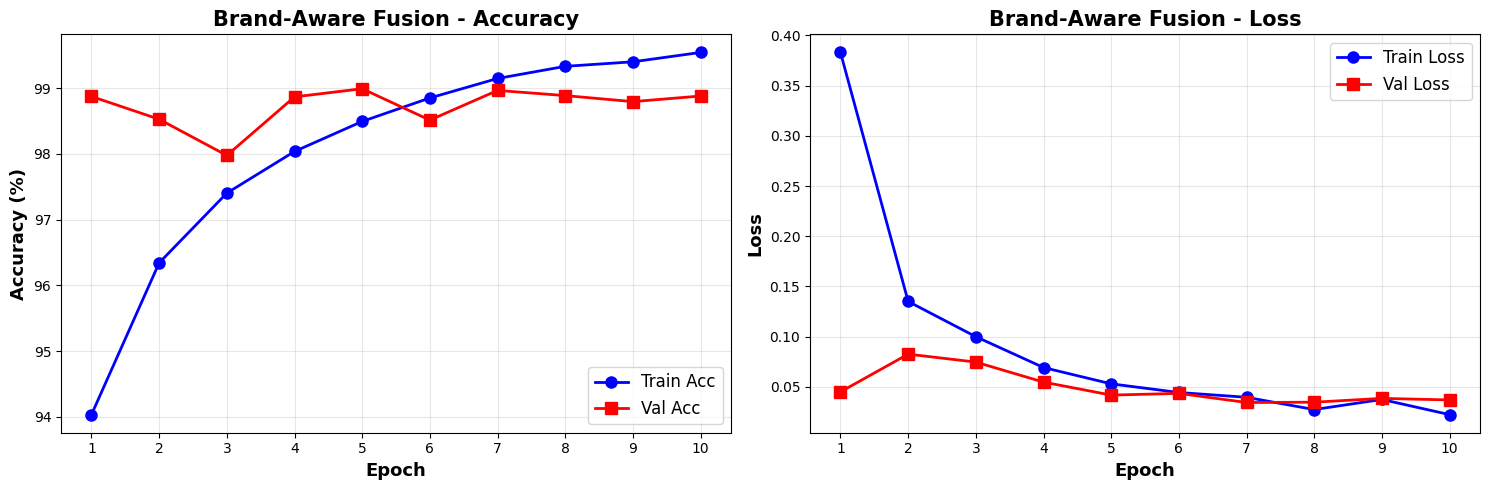

 Saved plot -> brand_aware_fusion_curves.png


In [12]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, CONFIG['epochs'] + 1)

# Plot accuracy
ax1.plot(epochs_range, [a*100 for a in history['train_acc']], 
         'b-o', label='Train Acc', linewidth=2, markersize=8)
ax1.plot(epochs_range, [a*100 for a in history['val_acc']], 
         'r-s', label='Val Acc', linewidth=2, markersize=8)
ax1.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
ax1. set_title('Brand-Aware Fusion - Accuracy', fontsize=15, fontweight='bold')
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(epochs_range)

# Plot loss
ax2.plot(epochs_range, history['train_loss'], 
         'b-o', label='Train Loss', linewidth=2, markersize=8)
ax2.plot(epochs_range, history['val_loss'], 
         'r-s', label='Val Loss', linewidth=2, markersize=8)
ax2.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax2.set_ylabel('Loss', fontsize=13, fontweight='bold')
ax2.set_title('Brand-Aware Fusion - Loss', fontsize=15, fontweight='bold')
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(epochs_range)

plt.tight_layout()
plt.savefig('brand_aware_fusion_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Saved plot -> brand_aware_fusion_curves.png")

In [13]:
print("\n" + "="*70)
print("Brand-Aware Fusion Model - Final Analysis")
print("="*70)

print(f"\n Dataset Statistics:")
print(f"  Training samples: {len(train_dataset):,}")
print(f"  Validation samples: {len(val_dataset):,}")
print(f"  Brands with images: {len(brand_to_images)}")

print(f"\n Performance:")
print(f"  Best Validation Accuracy: {best_val_acc*100:.2f}%")
print(f"  Final Training Accuracy: {history['train_acc'][-1]*100:.2f}%")
print(f"  Generalization Gap: {(history['train_acc'][-1] - history['val_acc'][-1])*100:.2f}%")

print(f"\n  Model Components:")
print(f"  Text Tower: 256-dim features (from trained CNN)")
print(f"  Image Tower: 512-dim features (from trained CNN)")
print(f"  Metadata: 20 → 64-dim features")
print(f"  Combined: 832-dim → Fusion classifier → 2 classes")

print(f"\n Key Features:")
print(f"  Brand-based text-to-image pairing")
print(f"  Metadata feature integration (20 features)")
print(f"  Semantic brand detection")
print(f"  Multi-modal learning (text + image + metadata)")

print("\n" + "="*70)


Brand-Aware Fusion Model - Final Analysis

 Dataset Statistics:
  Training samples: 61,076
  Validation samples: 15,270
  Brands with images: 297

 Performance:
  Best Validation Accuracy: 98.99%
  Final Training Accuracy: 99.54%
  Generalization Gap: 0.66%

  Model Components:
  Text Tower: 256-dim features (from trained CNN)
  Image Tower: 512-dim features (from trained CNN)
  Metadata: 20 → 64-dim features
  Combined: 832-dim → Fusion classifier → 2 classes

 Key Features:
  Brand-based text-to-image pairing
  Metadata feature integration (20 features)
  Semantic brand detection
  Multi-modal learning (text + image + metadata)

